Elon Musk ( CEO of Tesla and Space-X )


He’s one of the most famous personalities alive. He has been subject of controversy because of his tweets. His single tweet is enough to turn the market upside down. It would be interesting to analyze his conduct and reputation on twitter.

In [41]:
import tweepy
from collections import Counter
import pandas as pd
import re
import matplotlib.pyplot as plt 
import time
import warnings
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from wordcloud import WordCloud


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB


# For Deploy
import pickle
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.pipeline import make_pipeline
from nltk.tokenize import RegexpTokenizer

# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
nltk.download('omw-1.4')
stopwords = set(stopwords.words("english"))

# for showing all the plots inline
%matplotlib inline



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jogendra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jogendra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jogendra\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jogendra\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\jogendra\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jogendra\AppData\Roaming\nltk_data...
[nltk_data]   Pa

## Fetching and Preprocessing Tweets

Using Twitter API to fetch tweets about elon musk ( elon's tweet excluded ). 

In [42]:
token = "AAAAAAAAAAAAAAAAAAAAAJg2fwEAAAAAqbM4TApAkAV%2FM0cnxNe0eJD1bJM%3DJhvk7gW9q6fVpDz6u3qRDRrewTlxc6KADNtGZVCUrRgdsq0sdO"

client = tweepy.Client(token)
fields = ['author_id','entities','id','in_reply_to_user_id','referenced_tweets','text']

hashcounter = Counter()
elon_id = client.get_user(username='elonmusk')
print(elon_id.data.id)

query = "Elon Musk lang:en"
tdata = tweepy.Paginator(client.search_recent_tweets, query=query,
                              tweet_fields=fields, max_results=100).flatten(limit=3000)

tweets = []
without_mentions = []
hashtags = {}

c = 0
for t in tdata:
    # print(c, t)
    
    if t.get('author_id')!=elon_id:

        txt = t.text
        if t:
            ent = t.get('entities', {})
        
        # getting hashtags
        if ent:
            hashtags = ent.get('hashtags', [])
            tags = [ ta['tag'] for ta in hashtags]
            ment = ent.get('mentions', [])
            if ment:
                for i in ment:
                    txt = txt.replace(f"@{i['username']}", "")
            
        if hashtags:
            hashcounter.update(tags)
        
        tweets.append(t.text)
        without_mentions.append(txt)

        print(t)


# print(hashtags)

# for tag, count in hashcounter.most_common():
        # print(tag + ": " + str(count))

df = pd.DataFrame(tweets, columns=['tweets'])

df.head()


44196397
When Elon Musk accused Twitter of lying about how many bots were on this platform, Twitter snarked back "How could he know?  He only ever ran a bunch of random searches for keywords."

Yeah.  About that... https://t.co/n0aAdDQjJC
RT @TickerHistory: Elon Musk at his 18th birthday party (1989) https://t.co/0H0Qdc7sdb
i will sit here and create a ppt on why i will tell elon musk to go to hell whilst applauding my good sis if ya really want https://t.co/BpBaJBDo2O
RT @TheMayorOfLagos: One would think this is a common sense thing. Awon Elon Musk wannabe, at least you go reash him level before you start…
RT @larryelder: Elon Musk offered to buy the FBI, but Mark Zuckerberg refused to sell.
RT @realDailyWire: "Musk had cited Twitter underestimating bots as reason to cancel deal."
https://t.co/QU8bMAj0is
RT @israelUSAforeve: Raise your hand If you agree that Elon Musk is a better African American than Obama.
@myunclesmemes Thais is Elon Musk
RT @larryelder: Elon Musk offered to buy th

,tweets
0,When Elon Musk accused Twitter of lying about ...
1,RT @TickerHistory: Elon Musk at his 18th birth...
2,i will sit here and create a ppt on why i will...
3,RT @TheMayorOfLagos: One would think this is a...
4,RT @larryelder: Elon Musk offered to buy the F...


### Creating CSV File


In [43]:
df.to_csv("dataset.csv", index=False)

In [44]:
df = pd.read_csv("dataset.csv")
df.shape

(3000, 1)

# Sentiments

Now we need to know the sentiment of each tweet using `NLTK`

In [60]:
def sentiment(data):
    sia = SentimentIntensityAnalyzer()
    scores = sia.polarity_scores(data)
    return 'negative' if scores['neg'] > scores['pos'] else 'positive'

sentiments_using_SIA = df['tweets'].apply(lambda tweet: sentiment(tweet))


df['sentiment'] = sentiments_using_SIA
pd.DataFrame(sentiments_using_SIA.value_counts()).head()
# df.head(20)

,tweets
positive,2090
negative,910


# Text Preprocessing

1. removing links ( http or https ) and `RT :`


In [46]:
clean_tweets = []

def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text
df['tidy_tweets'] = without_mentions
    
for index, row in df.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.tidy_tweets.split() if 'http' not in word]
    clean_tweets.append(' '.join(words_without_links))

df['tidy_tweets'] = clean_tweets



df['tidy_tweets'] = np.vectorize(remove_pattern)(df['tidy_tweets'], r"RT\s*:")
df.head(10)

,tweets,sentiment,tidy_tweets
0,When Elon Musk accused Twitter of lying about ...,negative,When Elon Musk accused Twitter of lying about ...
1,RT @TickerHistory: Elon Musk at his 18th birth...,positive,Elon Musk at his 18th birthday party (1989)
2,i will sit here and create a ppt on why i will...,positive,i will sit here and create a ppt on why i will...
3,RT @TheMayorOfLagos: One would think this is a...,positive,One would think this is a common sense thing....
4,RT @larryelder: Elon Musk offered to buy the F...,negative,"Elon Musk offered to buy the FBI, but Mark Zu..."
5,"RT @realDailyWire: ""Musk had cited Twitter und...",negative,"""Musk had cited Twitter underestimating bots ..."
6,RT @israelUSAforeve: Raise your hand If you ag...,positive,Raise your hand If you agree that Elon Musk i...
7,@myunclesmemes Thais is Elon Musk,positive,Thais is Elon Musk
8,RT @larryelder: Elon Musk offered to buy the F...,negative,"Elon Musk offered to buy the FBI, but Mark Zu..."
9,RT @larryelder: Elon Musk offered to buy the F...,negative,"Elon Musk offered to buy the FBI, but Mark Zu..."


2. removing tweets with empty text

In [47]:
df = df[df['tidy_tweets']!='']
df.head()

,tweets,sentiment,tidy_tweets
0,When Elon Musk accused Twitter of lying about ...,negative,When Elon Musk accused Twitter of lying about ...
1,RT @TickerHistory: Elon Musk at his 18th birth...,positive,Elon Musk at his 18th birthday party (1989)
2,i will sit here and create a ppt on why i will...,positive,i will sit here and create a ppt on why i will...
3,RT @TheMayorOfLagos: One would think this is a...,positive,One would think this is a common sense thing....
4,RT @larryelder: Elon Musk offered to buy the F...,negative,"Elon Musk offered to buy the FBI, but Mark Zu..."


3. dropping duplicate rows


In [48]:
df.drop_duplicates(subset=['tidy_tweets'], keep=False)
df.head()

,tweets,sentiment,tidy_tweets
0,When Elon Musk accused Twitter of lying about ...,negative,When Elon Musk accused Twitter of lying about ...
1,RT @TickerHistory: Elon Musk at his 18th birth...,positive,Elon Musk at his 18th birthday party (1989)
2,i will sit here and create a ppt on why i will...,positive,i will sit here and create a ppt on why i will...
3,RT @TheMayorOfLagos: One would think this is a...,positive,One would think this is a common sense thing....
4,RT @larryelder: Elon Musk offered to buy the F...,negative,"Elon Musk offered to buy the FBI, but Mark Zu..."


In [49]:
# reset dataframe index
df = df.reset_index(drop=True)
df.head()

,tweets,sentiment,tidy_tweets
0,When Elon Musk accused Twitter of lying about ...,negative,When Elon Musk accused Twitter of lying about ...
1,RT @TickerHistory: Elon Musk at his 18th birth...,positive,Elon Musk at his 18th birthday party (1989)
2,i will sit here and create a ppt on why i will...,positive,i will sit here and create a ppt on why i will...
3,RT @TheMayorOfLagos: One would think this is a...,positive,One would think this is a common sense thing....
4,RT @larryelder: Elon Musk offered to buy the F...,negative,"Elon Musk offered to buy the FBI, but Mark Zu..."


4. Removing punctuations, numbers and special characters

In [50]:

df['absolute_tidy_tweets'] = df['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")

C:\Users\jogendra\AppData\Local\Temp\ipykernel_15576\3743940272.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['absolute_tidy_tweets'] = df['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")


5. Removing Stop words

In [51]:
#  Removing Stop words

stopwords_set = set(stopwords)
cleaned_tweets = []

for index, row in df.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.absolute_tidy_tweets.split() if not word in stopwords_set and '#' not in word.lower()]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))
    
df['absolute_tidy_tweets'] = cleaned_tweets
df.head()

,tweets,sentiment,tidy_tweets,absolute_tidy_tweets
0,When Elon Musk accused Twitter of lying about ...,negative,When Elon Musk accused Twitter of lying about ...,When Elon Musk accused Twitter lying many bots...
1,RT @TickerHistory: Elon Musk at his 18th birth...,positive,Elon Musk at his 18th birthday party (1989),Elon Musk th birthday party
2,i will sit here and create a ppt on why i will...,positive,i will sit here and create a ppt on why i will...,sit create ppt tell elon musk go hell whilst a...
3,RT @TheMayorOfLagos: One would think this is a...,positive,One would think this is a common sense thing....,One would think common sense thing Awon Elon M...
4,RT @larryelder: Elon Musk offered to buy the F...,negative,"Elon Musk offered to buy the FBI, but Mark Zu...",Elon Musk offered buy FBI Mark Zuckerberg refu...


6. Tokenization

In [52]:

tokenized_tweet = df['absolute_tidy_tweets'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [When, Elon, Musk, accused, Twitter, lying, ma...
1                    [Elon, Musk, th, birthday, party]
2    [sit, create, ppt, tell, elon, musk, go, hell,...
3    [One, would, think, common, sense, thing, Awon...
4    [Elon, Musk, offered, buy, FBI, Mark, Zuckerbe...
Name: absolute_tidy_tweets, dtype: object

7. Lemmatisation

In [53]:
word_lemmatizer = WordNetLemmatizer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
tokenized_tweet.head()

0    [When, Elon, Musk, accused, Twitter, lying, ma...
1                    [Elon, Musk, th, birthday, party]
2    [sit, create, ppt, tell, elon, musk, go, hell,...
3    [One, would, think, common, sense, thing, Awon...
4    [Elon, Musk, offered, buy, FBI, Mark, Zuckerbe...
Name: absolute_tidy_tweets, dtype: object

In [54]:
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

df['absolute_tidy_tweets'] = tokenized_tweet
df.head()

,tweets,sentiment,tidy_tweets,absolute_tidy_tweets
0,When Elon Musk accused Twitter of lying about ...,negative,When Elon Musk accused Twitter of lying about ...,When Elon Musk accused Twitter lying many bot ...
1,RT @TickerHistory: Elon Musk at his 18th birth...,positive,Elon Musk at his 18th birthday party (1989),Elon Musk th birthday party
2,i will sit here and create a ppt on why i will...,positive,i will sit here and create a ppt on why i will...,sit create ppt tell elon musk go hell whilst a...
3,RT @TheMayorOfLagos: One would think this is a...,positive,One would think this is a common sense thing....,One would think common sense thing Awon Elon M...
4,RT @larryelder: Elon Musk offered to buy the F...,negative,"Elon Musk offered to buy the FBI, but Mark Zu...",Elon Musk offered buy FBI Mark Zuckerberg refu...


## Pre-processing 'Key Phrases'

In [55]:

class PhraseExtract(object):
    def __init__(self):
        self.lemmatizer = nltk.WordNetLemmatizer()
        self.stemmer = nltk.stem.porter.PorterStemmer()
    
    def leaves(self, tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()

    def normalise(self, word):
        """Normalises words to lowercase and stems and lemmatizes it."""
        word = word.lower()
        # word = self.stemmer.stem_word(word) # We will loose the exact meaning of the word 
        word = self.lemmatizer.lemmatize(word)
        return word

    def acceptable_word(self, word):
        """Checks conditions for acceptable word: length, stopword. We can increase the length if we want to consider large phrase"""
        accepted = bool(3 <= len(word) <= 40
            and word.lower() not in stopwords
            and 'https' not in word.lower()
            and 'http' not in word.lower()
            and '#' not in word.lower()
            )
        return accepted

    def get_terms(self, tree):
        for leaf in self.leaves(tree):
            term = [ self.normalise(w) for w,t in leaf if self.acceptable_word(w) ]
            yield term



Grammatical rule to identify phrases

In [56]:
sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""
chunker = nltk.RegexpParser(grammar)

In [57]:
key_phrases = []
phrase_extract = PhraseExtract()

for index, row in df.iterrows(): 
    toks = nltk.regexp_tokenize(row.tidy_tweets, sentence_re)
    postoks = nltk.tag.pos_tag(toks)
    tree = chunker.parse(postoks)

    terms = phrase_extract.get_terms(tree)
    tweet_phrases = []

    for term in terms:
        if len(term):
            tweet_phrases.append(' '.join(term))
    
    key_phrases.append(tweet_phrases)
    
key_phrases[:10]

[['elon musk',
  'twitter',
  'many bot',
  'platform',
  'twitter',
  'bunch',
  'random search',
  'keywords ." y eah'],
 ['elon musk', 'birthday party'],
 ['ppt', 'musk', 'good si'],
 ['common sense thing', 'awon elon musk wannabe', 'level'],
 ['elon musk', ' fbi', 'mark zuckerberg'],
 ['musk', 'twitter', 'bot', 'reason', 'deal'],
 ['hand', 'elon musk', 'african american', 'obama'],
 ['thai', 'elon musk'],
 ['elon musk', ' fbi', 'mark zuckerberg'],
 ['elon musk', ' fbi', 'mark zuckerberg']]

In [58]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor

textblob_key_phrases = []
extractor = ConllExtractor()
for index, row in df.iterrows():
    # filerting out all the hashtags
    words_without_hash = [word for word in row.tidy_tweets.split() if '#' not in word.lower()]
    
    hash_removed_sentence = ' '.join(words_without_hash)
    
    blob = TextBlob(hash_removed_sentence, np_extractor=extractor)
    textblob_key_phrases.append(list(blob.noun_phrases))

textblob_key_phrases[:10]

KeyboardInterrupt: 

In [ ]:
df['key_phrases'] = textblob_key_phrases

## Visualization

In [ ]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()


df.head()

,tweets,sentiment,tidy_tweets,absolute_tidy_tweets,key_phrases
0,RT @larryelder: Elon Musk offered to buy the F...,negative,"Elon Musk offered to buy the FBI, but Mark Zu...",Elon Musk offered buy FBI Mark Zuckerberg refu...,"[elon musk, fbi, mark zuckerberg]"
1,RT @BrutIndia: Only Elon Musk and Jeff Bezos a...,positive,Only Elon Musk and Jeff Bezos are wealthier t...,Only Elon Musk Jeff Bezos wealthier selfmade I...,"[elon musk, jeff bezos, self-made indian man]"
2,RT @larryelder: Elon Musk offered to buy the F...,negative,"Elon Musk offered to buy the FBI, but Mark Zu...",Elon Musk offered buy FBI Mark Zuckerberg refu...,"[elon musk, fbi, mark zuckerberg]"
3,MAKING A LONG TERM BET ON ELON MUSK @elonmusk ...,positive,MAKING A LONG TERM BET ON ELON MUSK,MAKING A LONG TERM BET ON ELON MUSK,"[long term bet, elon musk]"
4,RT @Reuters: Elon Musk says world still needs ...,positive,Elon Musk says world still needs oil and gas,Elon Musk say world still need oil gas,[elon musk]


#### Common positive tweets

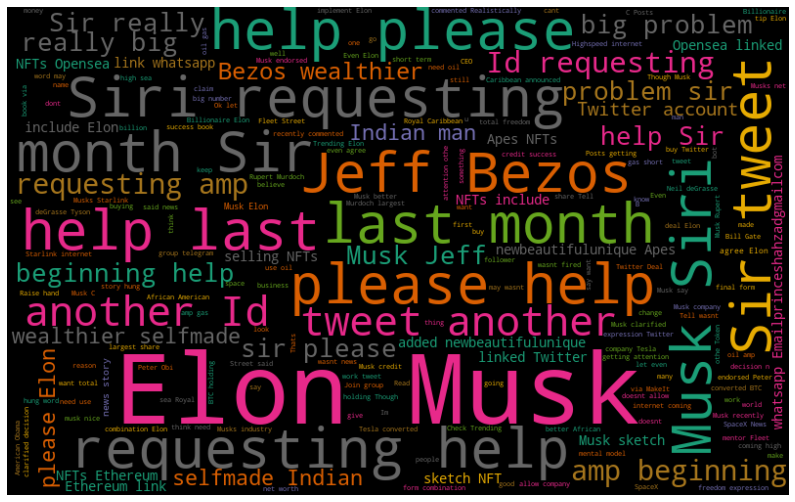

In [ ]:
all_words = ' '.join([text for text in df['absolute_tidy_tweets'][df.sentiment == 'positive']])
generate_wordcloud(all_words)

#### Common negative tweets

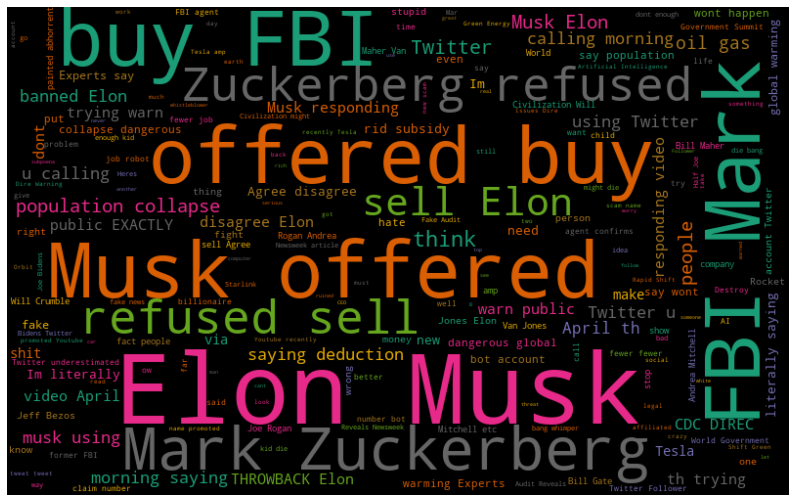

In [ ]:
all_words = ' '.join([text for text in df['absolute_tidy_tweets'][df.sentiment == 'negative']])
generate_wordcloud(all_words)

#### Common Hashtags

[]


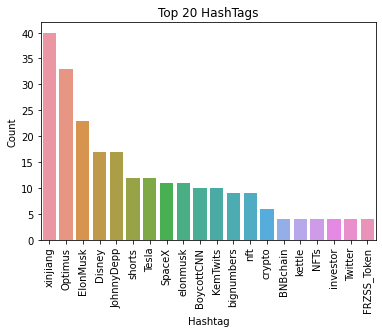

In [ ]:
print(hashtags)

import seaborn as sns
hashs = []
value = []
for tag, count in hashcounter.most_common(20):
        hashs.append(tag)
        value.append(count)

data = pd.DataFrame({"Hashtag": hashs, "Count":value})
ax = sns.barplot(data=data, x="Hashtag", y="Count")
plt.xticks(rotation=90)
plt.title("Top 20 HashTags")
plt.show()

In [ ]:
df2 = df[df['key_phrases'].str.len()>0]


# Vertorization

In [ ]:
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
# TF-IDF feature matrix
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(df2['absolute_tidy_tweets'])

In [ ]:
phrase_sents = df2['key_phrases'].apply(lambda x: ' '.join(x))

tfidf_phrase_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2)
tfidf_phrase_feature = tfidf_phrase_vectorizer.fit_transform(phrase_sents)


# Sentiment Analysis

In [ ]:
target_variable = df2['sentiment'].apply(lambda x: 0 if x=='negative' else 1)


In [ ]:
def plot_confusion_matrix(matrix):
    plt.clf()
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Set2_r)
    classNames = ['Positive', 'Negative']
    plt.title('Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(matrix[i][j]))
    plt.show()


In [ ]:
def naive_model(X_train, X_test, y_train, y_test):
    naive_classifier = GaussianNB()
    naive_classifier.fit(X_train.toarray(), y_train)

    # predictions over test set
    predictions = naive_classifier.predict(X_test.toarray())

    # calculating Accuracy Score
    print(f'Accuracy Score - {accuracy_score(y_test, predictions)}')
    conf_matrix = confusion_matrix(y_test, predictions, labels=[True, False])
    plot_confusion_matrix(conf_matrix)

TF-IDF word features

Accuracy Score - 0.8613303269447576


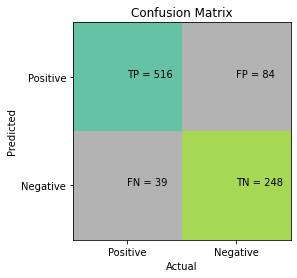

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_word_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

TF-IDF Phrase features

Accuracy Score - 0.7688838782412627


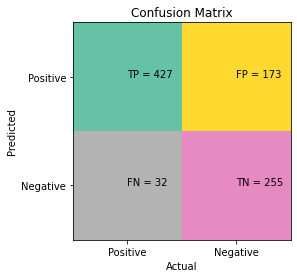

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_phrase_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

In [ ]:
pipeline_ls = make_pipeline(CountVectorizer(max_df=0.90, min_df=2,
 tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'),
  LogisticRegression())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df2.tweets, df2.sentiment)

In [ ]:
pipeline_ls.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.9, min_df=2, stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)),
                ('logisticregression', LogisticRegression())])

In [ ]:
pipeline_ls.score(X_test,y_test) 

0.9052774018944519

In [ ]:
p = ['Elon Musk and other Billionaires had money on my head cuz I’m a “whistle blower” https://t.co/BYphx2uSDq']
result = pipeline_ls.predict(p)


In [ ]:
print(result)

['positive']
